### Import Livneh reanalysis data

In [1]:
import numpy as np
import scipy as sp
import netCDF4 as nc4

In [2]:
datapath_input = '/data1/adalbert/livneh/Livneh.AtmVar.CA.4km.2003_2013.nc'
datapath_output= '/data1/adalbert/livneh/Livneh.LndVar.CA.4km.2003_2013.nc'

In [3]:
f_in = nc4.Dataset(datapath_input,'r')
f_out= nc4.Dataset(datapath_output,'r')

In [4]:
f_in.variables.keys()

[u'lon', u'lat', u'time', u'Prec', u'Tmax', u'Tmin', u'wind']

In [5]:
f_out.variables.keys()

[u'lon',
 u'lat',
 u'lev',
 u'time',
 u'Baseflow',
 u'GroundHeat',
 u'LatentHeat',
 u'NetRad',
 u'PETLong',
 u'PETNatVeg',
 u'PETShort',
 u'Runoff',
 u'SWE',
 u'SensibleHeat',
 u'SoilMoist',
 u'TotalET',
 u'WDEW']

In [6]:
# Extract data from NetCDF file
def extract_data(nc_fid, fields):
    lats = nc_fid.variables['lat'][:]  # extract/copy the data
    lons = nc_fid.variables['lon'][:]
    time = nc_fid.variables['time'][:]
    field = []
    for f in fields:
        field.append(nc_fid.variables[f][:])
    field = np.stack(field)
    return lats, lons, time, field

In [10]:
variables = [u'Prec', u'Tmax', u'Tmin', u'wind']
lats_in, lons_in, time_in, input_data = extract_data(f_in, variables)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in less


In [11]:
input_data = input_data.transpose((1,2,3,0))

In [12]:
lats_out, lons_out, time_out, swe = extract_data(f_out, ['SWE'])
swe = swe.transpose((1,2,3,0))

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in greater


In [13]:
input_data.shape, swe.shape

((4018, 321, 321, 4), (4018, 321, 321, 1))

In [14]:
metadata_in = zip(lats_in, lons_in, time_in)
metadata_out= zip(lats_out, lons_out, time_out)

### Split into train/test, save data to numpy format

In [15]:
output_dir = "./livneh/"

import os
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [16]:
frac_train = 0.8
idx_train = int(len(input_data) * frac_train)
trainA = input_data[:idx_train]
testA = input_data[idx_train:]
trainA_meta = metadata_in[:idx_train]
testA_meta = metadata_in[idx_train:]

trainB = swe[:idx_train]
testB = swe[idx_train:]
trainB_meta = metadata_out[:idx_train]
testB_meta = metadata_out[idx_train:]


In [ ]:
# save train/test files

np.savez_compressed(output_dir + "trainA.npz", data=trainA, variables=variables, metadata=trainA_meta)
np.savez_compressed(output_dir + "trainB.npz", data=trainB, variables=['SWE'], metadata=trainB_meta)
np.savez_compressed(output_dir + "testA.npz", data=testA, variables=variables, metadata=testA_meta)
np.savez_compressed(output_dir + "testB.npz", data=testB, variables=['SWE'], metadata=testB_meta)

In [ ]:
# save each sample in its own file
# this mimicks the way GAN frameworks work currently 

for data, meta, split, fields in zip([trainA, trainB, testA, testB], 
                             [trainA_meta, trainB_meta, testA_meta, testB_meta], 
                             ["trainA", "trainB", "testA", "testB"],
                             [variables, ['SWE'], variables, ['SWE']]):
    print "Dumping %s split..." % split 
    cur_dir = output_dir + split + "/"
    if not os.path.exists(cur_dir):
        os.makedirs(cur_dir)
    for i,(sample,info) in enumerate(zip(data,meta)):
        np.savez_compressed(cur_dir + "%s.npz"%i, data=sample, variables=fields, metadata=info)
 
    

## Inspect saved samples

In [27]:
x = np.load(output_dir + "trainA/100.npz")
y = np.load(output_dir + "trainB/100.npz")

In [28]:
x['data'].shape, y['data'].shape

((321, 321, 4), (321, 321, 1))

In [21]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

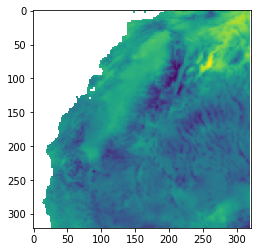

In [22]:
plt.imshow(x['data'][...,2])

Text(0.5,0,'Data value')

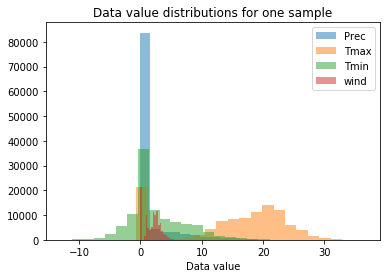

In [23]:
for i,v in enumerate(variables):
    plt.hist(np.nan_to_num(x['data'][...,i].flatten()), alpha=0.5, label=v, bins=20)
plt.legend(loc="best")
plt.title("Data value distributions for one sample")
plt.xlabel("Data value")

In [24]:
from skimage.transform import resize


In [25]:
resize(x['data'], (256,256)).shape

/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


(256, 256, 4)

In [32]:
newarr = []
for x in trainA[:10]:
    newarr.append(resize(x, (256,256)))
np.stack(newarr).shape

(10, 256, 256, 4)

In [39]:
tmp = np.nan_to_num(trainA[:10])

In [40]:
tmp = -1 + 2 * (tmp - tmp.min((1,2))[:, np.newaxis,np.newaxis]) / (tmp.max((1,2))[:, np.newaxis,np.newaxis] - tmp.min((1,2))[:, np.newaxis,np.newaxis])
        

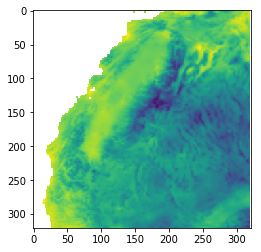

In [54]:
plt.imshow(trainA[0][...,2])

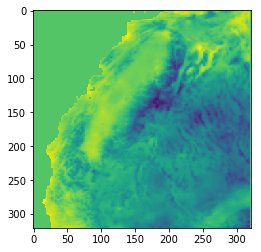

In [56]:
plt.imshow(tmp[0][...,2])

In [60]:
np.dstack((tmp[0], np.zeros_like(tmp[0]), np.zeros_like(tmp[0]))).shape

(321, 321, 12)

In [61]:
import torch

In [62]:
t = torch.from_numpy(tmp[0])

In [63]:
t.size()

torch.Size([321, 321, 4])

In [88]:
def one_to_three_channels(img):
    if img.size()[1]==1:
        return torch.cat((img.float(), torch.from_numpy(np.zeros(img.size())).float(), torch.from_numpy(np.zeros(img.size())).float()), 
          dim=2).size()
    else:
        return img

In [92]:
one_to_three_channels(t[...,0]).size()

torch.Size([321, 321])